In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
numpy.random.seed(410)

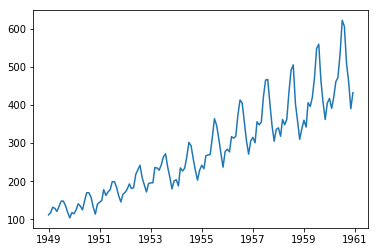

In [17]:
series = pd.read_csv('international-airline-passengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
plt.plot(series)
plt.show()

In [18]:
series.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60, dtype: int64

In [19]:
series.columns = ['mothly_passengers']

In [20]:
series.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60, dtype: int64

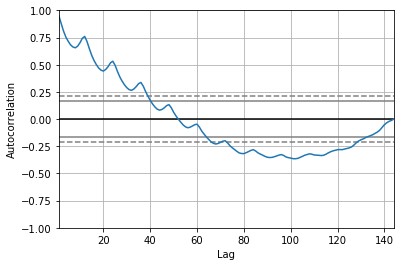

In [21]:
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
plt.show()

In [22]:
# Check Stationary
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(9,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='green', label='Rolling Mean')
    std = plt.plot(rolstd, color='red', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

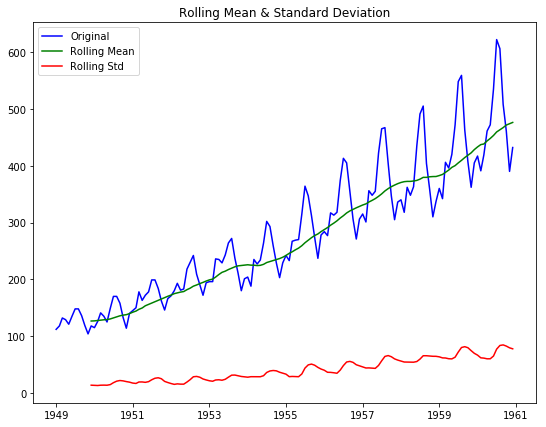

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [23]:
test_stationarity(series)

# not stationary
# mean is changing along the time
# Test Statistics is higher than any Critical Value

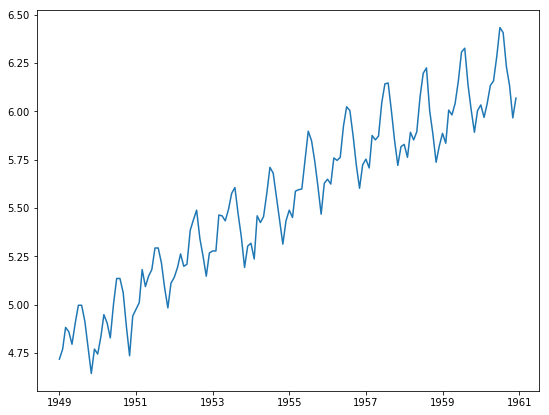

In [25]:
# try to make the data tom stationary first
## reduce trend by using log()
import numpy as np

ts_log = np.log(series)
plt.figure(figsize=(9,7))
plt.plot(ts_log)
plt.show()

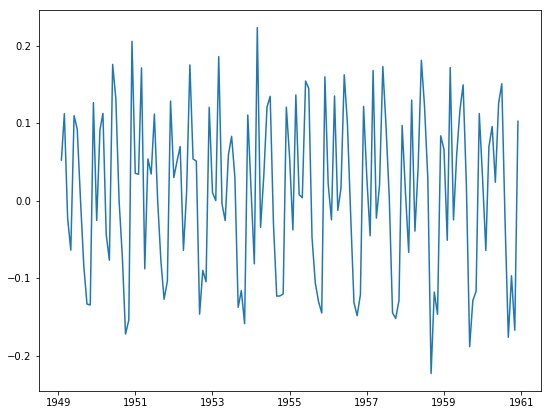

In [98]:
## differentiating
## both series and ts_log are showing seasonality, so, I will just try differentiating and decomposing

ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(9,7))
plt.plot(ts_log_diff)
plt.show()

In [99]:
ts_log_diff.head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60, dtype: float64

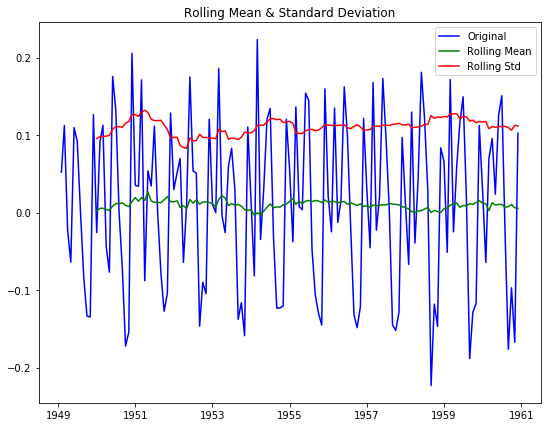

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [100]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# It's lower than 10% Critical Value, which means there is 90% confidence that the data is stationary now

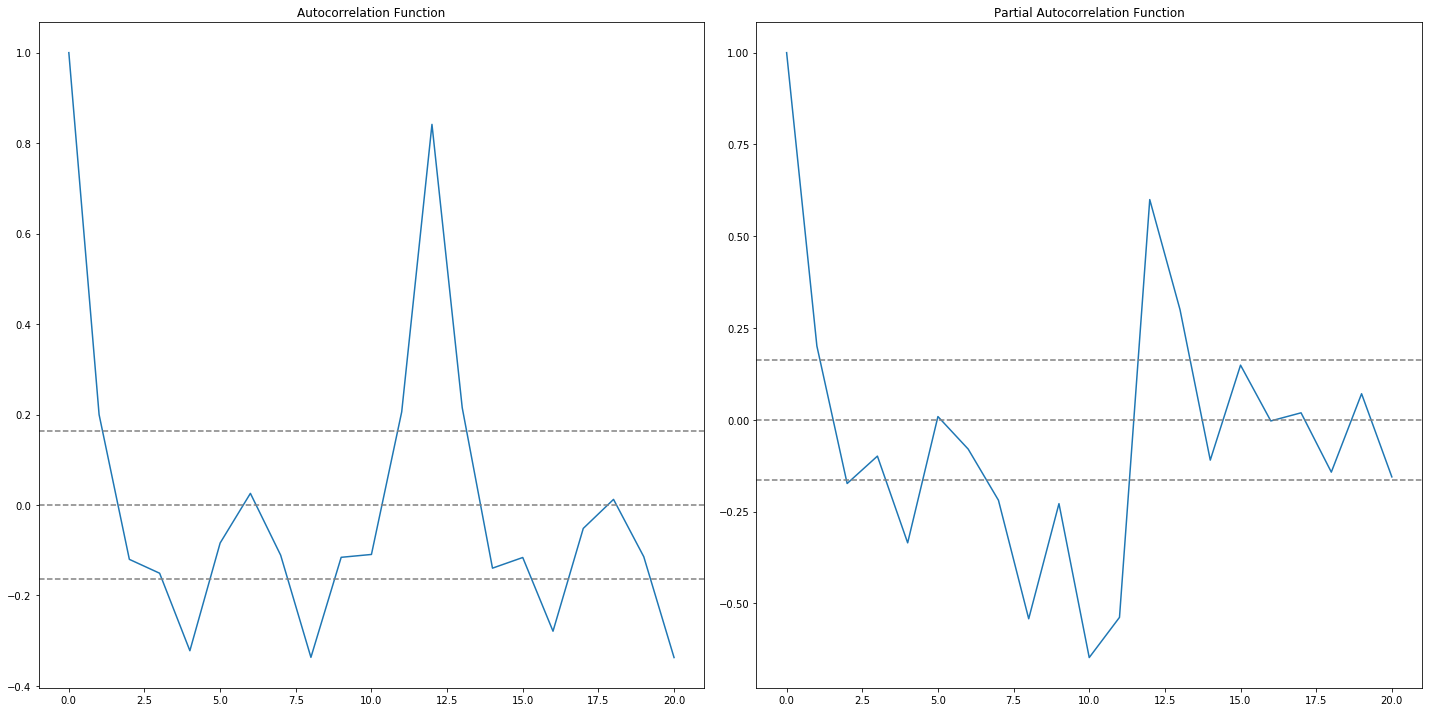

In [101]:
# try forcasting to see how it works
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,10))

#Plot ACF: 
## q – The lag value where the ACF chart crosses the upper confidence interval for the first time (in this case q=2)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
## p – The lag value where the PACF chart crosses the upper confidence interval for the first time (in this case p=2)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

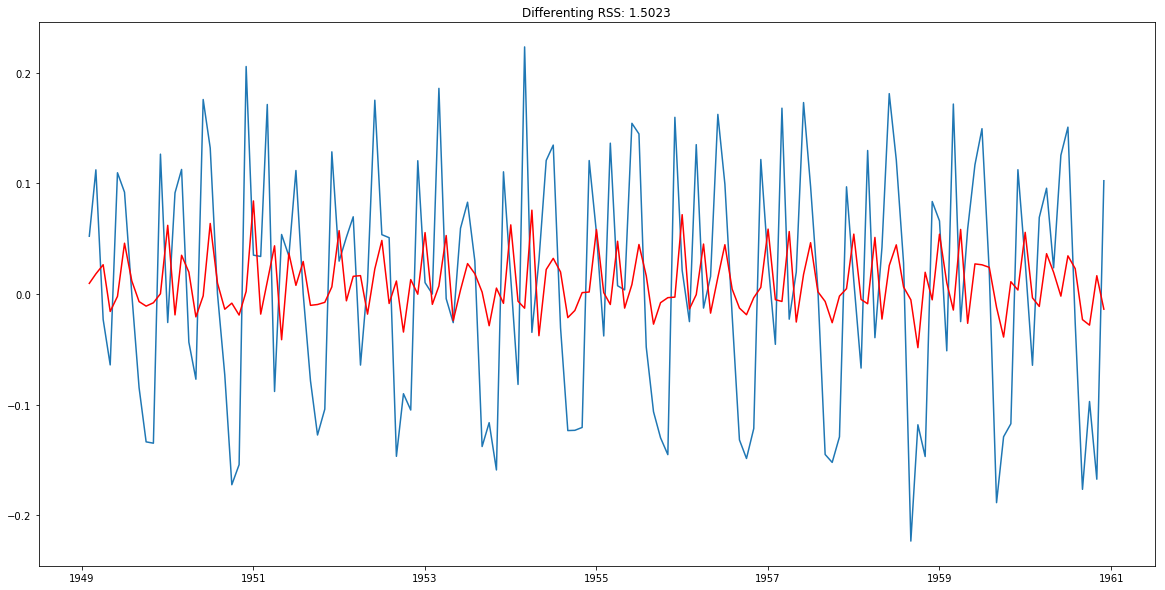

In [102]:
from statsmodels.tsa.arima_model import ARIMA
# RSS is for the values of residuals

# AR model
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1) 
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Differenting RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.show()

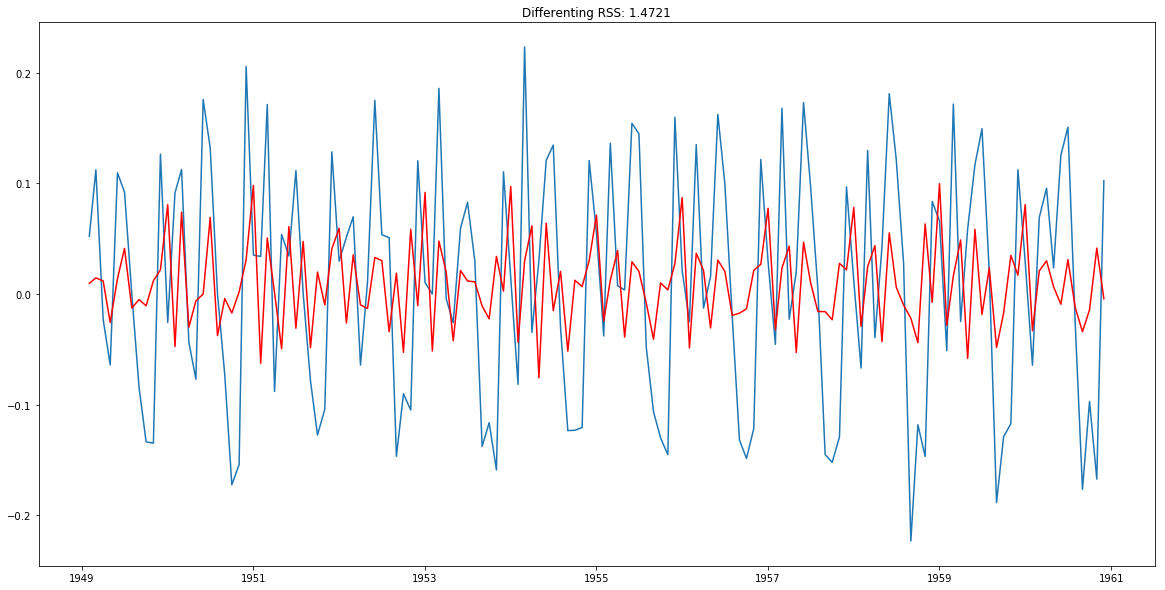

In [103]:
# MA Model

model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Differenting RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.show()

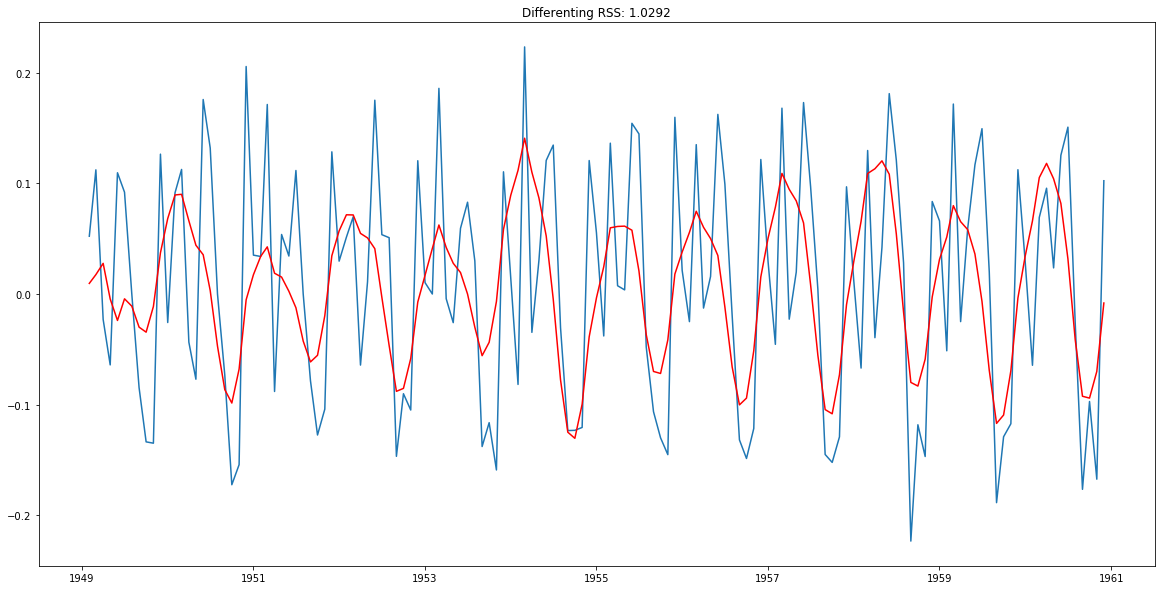

In [104]:
# combined mobel

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Differenting RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

In [105]:
# Based on RSS above, Combined model for Differenting is better, try to see forcasted results
## Scale back to original value, and see how this combined value performs

# Step 1 - store predicted result as seperated result
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [106]:
# Step 2 - Convert the differencing to log scale
## Add these differences consecutively to the base number
## An easy way to do it is to first determine the cumulative sum at index and then add it to the base number

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [107]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

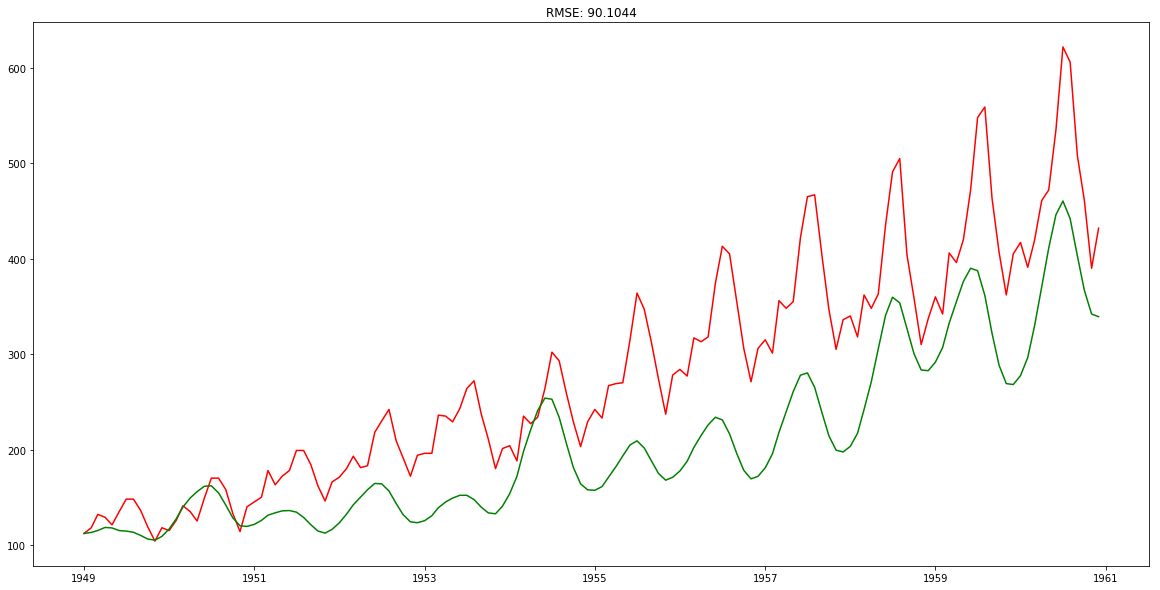

In [108]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(20,10))
plt.plot(series, color='red')
plt.plot(predictions_ARIMA, color='green')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-series)**2)/len(series)))
plt.show()

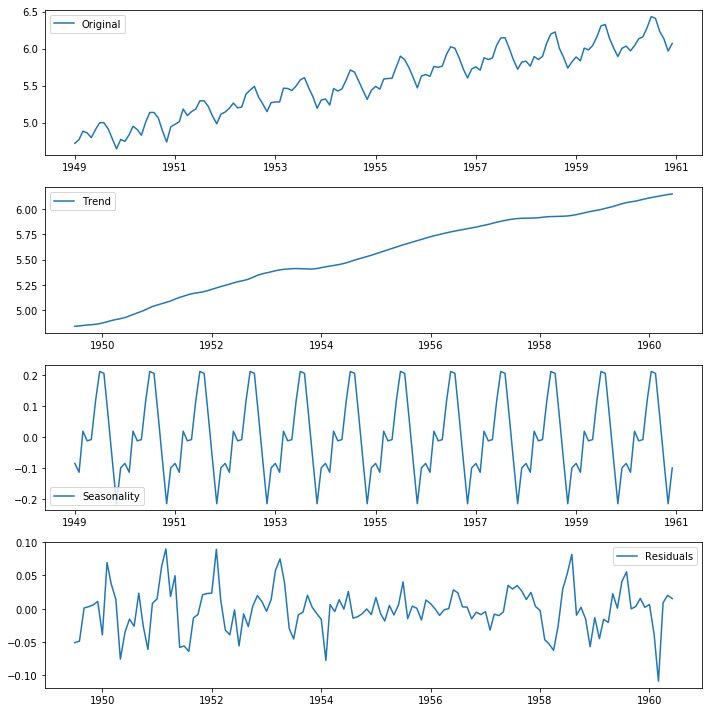

In [68]:
## try decomposing, and see whether it could make it better

from statsmodels.tsa.seasonal import seasonal_decompose

# trend, seasonality are separated out from data, and we can model the residuals
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

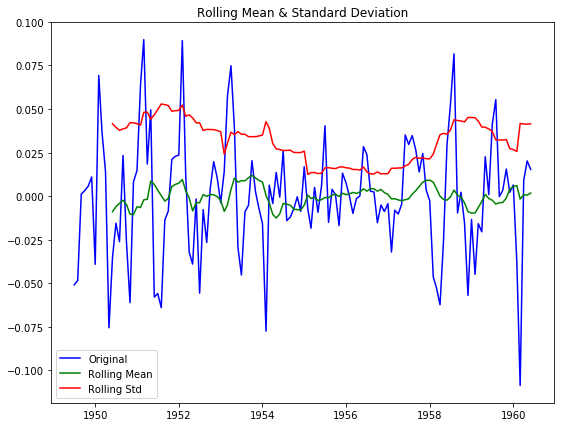

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (5%)           -2.885538e+00
Critical Value (1%)           -3.485122e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [69]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# This one has even lower than 1% Critical Value, which means 99% confidence for stationary
## but it's mean and variance looks more unstable

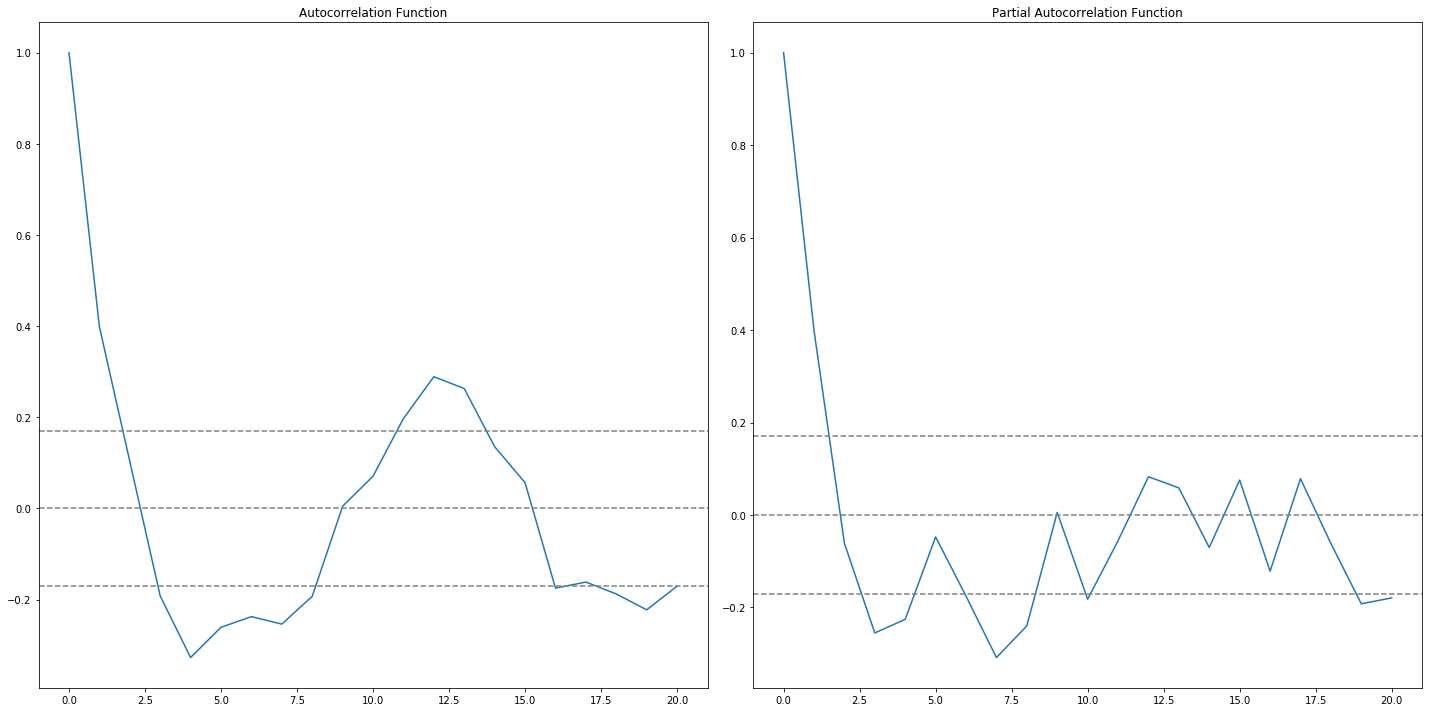

In [70]:
# try forecast with decomposed result

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_decompose, nlags=20)
lag_pacf = pacf(ts_log_decompose, nlags=20, method='ols')

plt.figure(figsize=(20,10))

#Plot ACF: 
## q – The lag value where the ACF chart crosses the upper confidence interval for the first time (in this case q=2)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
## p – The lag value where the PACF chart crosses the upper confidence interval for the first time (in this case p=2)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

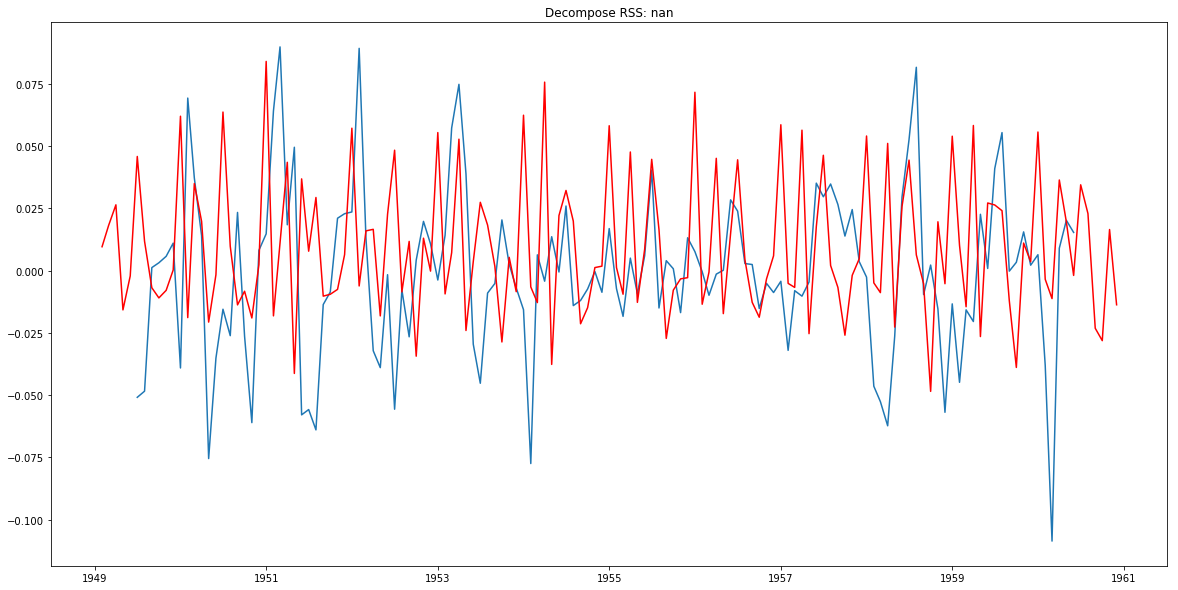

In [94]:
# AR model
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1) 
plt.figure(figsize=(20,10))
plt.plot(ts_log_decompose)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Decompose RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_decompose)**2))
plt.show()

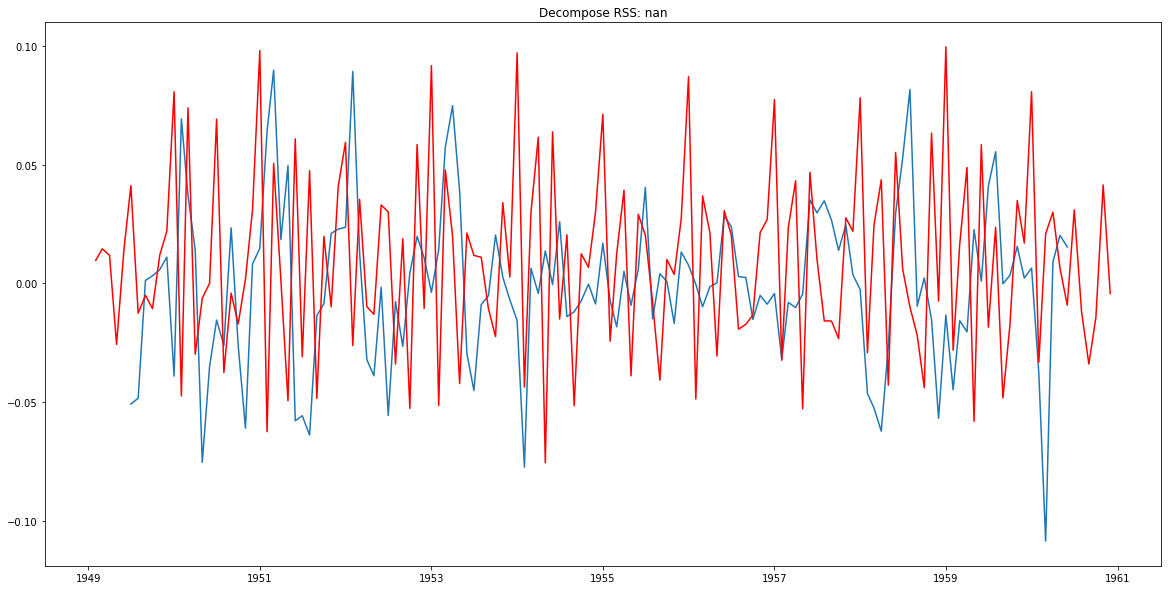

In [95]:
# MA Model

model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(20,10))
plt.plot(ts_log_decompose)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Decompose RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_decompose)**2))
plt.show()

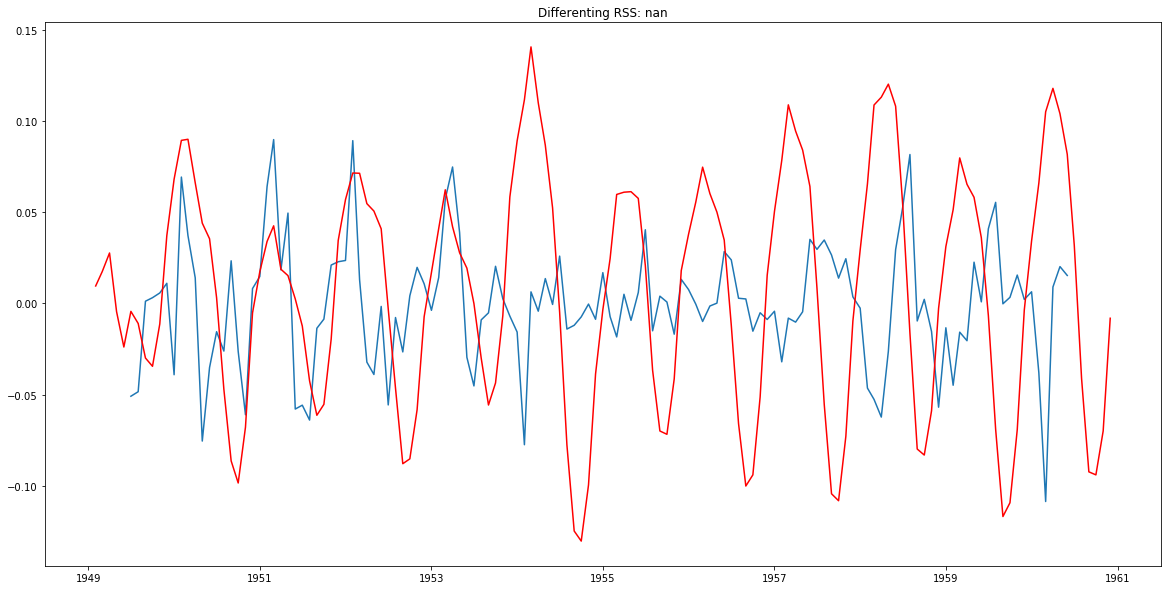

In [97]:
# combined mobel

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(20,10))
plt.plot(ts_log_decompose)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Differenting RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_decompose)**2))
plt.show()